In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
from keras_preprocessing.sequence import pad_sequences

df = pd.read_pickle('final_df.pkl')
X= df['text']
y= df['sentiment']

##0.2 so that training data is 80%, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69, stratify = y)

tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
dic_vocabulary = tokenizer.word_index

# Padding all reviews to fixed length 100
maxlen = 100
X_train_pad = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test_pad = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [2]:
from numpy import asarray
from numpy import zeros
embeddings_dictionary = dict()
glove_file = open('glove.6B.300d.txt', encoding="utf8")
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

# Create Embedding Matrix having 50 columns
# Containing 50-dimensional GloVe word embeddings for all words in our corpus.
embeddings = np.zeros((len(dic_vocabulary)+1, 300))
for word, index in dic_vocabulary.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embeddings[index] = embedding_vector

# Print Embedding Matrix shape
embeddings.shape

(177285, 300)

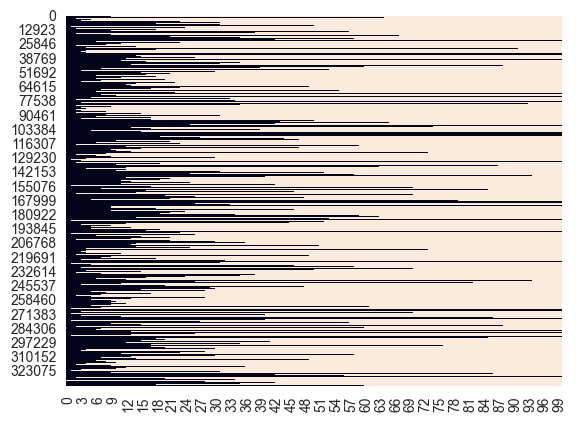

In [3]:
##Visuzaling the padding on the train set
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(X_train_pad==0, vmin=0, vmax=1, cbar=False)
plt.show()

In [4]:
import keras.backend as K

def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [5]:
##Making the framework for the neural network
from keras import Sequential
from keras.layers import Embedding, Dropout, Dense, LSTM

model = Sequential()
model.add(Embedding(input_dim=embeddings.shape[0], output_dim=embeddings.shape[1],
                    weights=[embeddings], input_length=X_train_pad.shape[1], trainable=False, input_shape=(maxlen,), mask_zero=True))
model.add(LSTM(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer='adam', metrics=[get_f1])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 300)          53185500  
                                                                 
 lstm (LSTM)                 (None, 16)                20288     
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 53,205,805
Trainable params: 20,305
Non-trainable params: 53,185,500
_________________________________________________________________


In [6]:
##Defining class weight, since positive class is twice as big as the negative class
class_weight = {0: 2.,
                1: 1.}
lstm_model = model.fit(X_train_pad, y_train, batch_size=64, epochs=5, class_weight=class_weight)

Epoch 1/5
5250/5250 [==============================] - 166s 31ms/step - loss: 0.4100 - get_f1: 0.8994
Epoch 2/5
5250/5250 [==============================] - 167s 32ms/step - loss: 0.3437 - get_f1: 0.9180
Epoch 3/5
5250/5250 [==============================] - 166s 32ms/step - loss: 0.3236 - get_f1: 0.9239
Epoch 4/5
5250/5250 [==============================] - 169s 32ms/step - loss: 0.3122 - get_f1: 0.9272
Epoch 5/5
5250/5250 [==============================] - 170s 32ms/step - loss: 0.3036 - get_f1: 0.9293


import matplotlib.pyplot as plt

plt.plot(lstm_model.history['get_f1'])
plt.plot(lstm_model.history['val_get_f1'])
plt.title('Model F1 score')
plt.ylabel('F1 score')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(lstm_model.history['loss'])
plt.plot(lstm_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [7]:
predictions = model.predict(X_test_pad)
lstm_predictions = list(map(lambda x: 0 if x<0.5 else 1, predictions))

2625/2625 [==============================] - 26s 10ms/step


In [8]:
from sklearn.metrics import f1_score
f1_score(y_test, lstm_predictions)

0.924907451609126

In [9]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_test, lstm_predictions), recall_score(y_test, lstm_predictions)

(0.9538875986994891, 0.8976362809888457)

In [13]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, lstm_predictions)

array([[24316,  2482],
       [ 5855, 51343]], dtype=int64)